Learn the inter-grid operator ratio for interface problems using multigrid framework,
* Dataset is constructed by changing RHS 
* Restriction and Prolongation operations are followed by a split operation
* Kernels for some part of fields are learned 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from FEANet.mesh import MeshHandler
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet

from Utils import plot
from Data.dataset import RHSDataSet

In [2]:
training_set = RHSDataSet('Data/poisson2d_rhs_17x17.h5', case='train')
test_set = RHSDataSet('Data/poisson2d_rhs_17x17.h5', case='test')

train_dataloader = DataLoader(training_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)

In [3]:
linear_tensor_R = torch.asarray([[1, 2, 1],
                                 [2, 4, 2],
                                 [1, 2, 1]], dtype=torch.float32) / 16.0
linear_tensor_P = torch.asarray([[1, 2, 1],
                                 [2, 4, 2],
                                 [1, 2, 1]], dtype=torch.float32) / 4.0
linear_ratio = torch.asarray([4.,1.], dtype=torch.float32)

In [4]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, size, n):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.property = [1, 20] # homogeneous problem
        self.plate = Geometry(nnode_edge = n+1)
        self.grid = MeshHandler(size, prop=self.property, nnode_edge=n+1)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.InstantiateFEANet()
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, self.plate.geometry_idx, self.plate.boundary_value)

    def IsCoarsest(self):
        return self.n == 2
        
    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

    def Relax(self, v, f, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iteration
        '''
        v = self.jac.jacobi_convolution(v, f, n_iter=num_sweeps_down)
        return v


class RestrictionNet(nn.Module):
    '''Given an initial R kernel'''
    def __init__(self, linear_tensor_R):
        super(RestrictionNet, self).__init__()
        self.n_channel = 16
        self.net = nn.Conv2d(in_channels=self.n_channel,out_channels=1, kernel_size=3, stride=2, bias=False) # restriction
        for i in range(self.n_channel):
            self.net.state_dict()['weight'][0][i] = linear_tensor_R
    def forward(self, x_split):
        '''The input should have already been splitted'''
        return self.net(x_split)

class ProlongationNet(nn.Module):
    '''Given an initial P kernel'''
    def __init__(self, linear_tensor_P):
        super(ProlongationNet, self).__init__()
        self.n_channel = 16
        self.net = nn.ConvTranspose2d(in_channels=self.n_channel,out_channels=1, kernel_size=3, stride=2, padding=1, bias=False) # interpolation
        for i in range(self.n_channel):
            self.net.state_dict()['weight'][i][0] = linear_tensor_P
            
    def forward(self, x_split): 
        '''The input should have already been splitted'''
        return self.net(x_split)

class MultiGrid(nn.Module):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n, linear_tensor_R, linear_tensor_P, linear_ratio):
        super(MultiGrid, self).__init__()

        # Problem parameters
        self.size = 2
        self.n = n # number of grid intervals for finest grid edges
        self.L = int(np.log2(n)) # multigrid iteration
        self.solution = []
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        # Inter-grid communication network models
        self.conv = RestrictionNet(linear_tensor_R)
        self.deconv = ProlongationNet(linear_tensor_P)
        self.w = nn.Parameter(linear_ratio)
        
        self.conv.requires_grad_(True)
        self.deconv.requires_grad_(True)
        self.w.requires_grad_(False)
    
    def GridDict(self):
        grids = {}
        for i in range(self.L):
            grids[i] = SingleGrid(self.size, self.n_arr[i])
        return grids

    def SizeArray(self):
        n_arr = []
        for i in range(self.L):
            n_arr.append(int(self.n/(2.**i)))
        n_arr = np.array(n_arr)
        return n_arr

    def Restrict(self, rF):
        '''
        Perform restriction operation to down sample to next (coarser) level
        Note: rF has already been splitted
        '''
        rFC = self.conv(rF[:, :, 1:-1, 1:-1].clone())
        rFC = F.pad(rFC,(1,1,1,1),"constant",0) # pad the coarse-level residual with zeros
        return rFC

    def Interpolate(self, eFC):
        '''
        Perform interpolation and upsample to previous (finer) level 
        Note: eFC has already been splitted
        '''
        eF = self.deconv(eFC.clone())
        return eF 

    def loss(self, x):
        "Compute the loss after m iterations"
        res1 = self.f - self.grids[0].Knet(x)
        return torch.mean(torch.norm(res1[:, :, 1:-1, 1:-1].clone(), dim=(2,3)))

    def random_sampling(self, v):
        d1, d2, d3, d4 = v.shape
        for i in range(d1):
            for j in range(d2):
                coef = 10*np.random.rand(2) - 5
                v[i, j, :, :] = torch.from_numpy(coef[0]*np.random.random((d3,d4)) + coef[1])

    def forward(self, F):
        '''Input is RHS field F'''
        self.f = self.grids[0].fnet(F) # assign the finest rhs 
        self.v = torch.zeros_like(F, requires_grad=False, dtype=torch.float32) # initial solution
        self.random_sampling(self.v)
        U = torch.clone(self.v)
        return self.iterate(U, self.f)

    def iterate(self, x, f):
        '''Input x is the initial solution on the finest grid'''
        n_batches = x.shape[0]
        n_relax = 1 # number of relaxations
        self.grids[0].v = x
        self.grids[0].f = f
        self.grids[0].v = self.grids[0].Relax(self.grids[0].v, self.grids[0].f, n_relax)

        for j in range(0, self.L-1):
            rF = self.grids[j].f-self.grids[j].Knet(self.grids[j].v)
            rF = self.grids[j].Knet.split_x(rF)
            self.grids[j+1].f = self.w[0]*self.Restrict(rF)
            self.grids[j+1].v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False)
            self.grids[j+1].v = self.grids[j+1].Relax(self.grids[j+1].v, self.grids[j+1].f, n_relax)

        self.grids[self.L-1].v = self.grids[self.L-1].Relax(self.grids[self.L-1].v, self.grids[self.L-1].f, n_relax)

        for j in range(self.L-2,-1,-1):
            eFC = self.grids[j+1].Knet.split_x(self.grids[j+1].v)
            eF_delta = self.w[1]*self.Interpolate(eFC)
            self.grids[j].v = self.grids[j].v + eF_delta
            self.grids[j].v = self.grids[j].Relax(self.grids[j].v, self.grids[j].f, n_relax)

            # zero out the previous level solution
            self.grids[j+1].v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False) 

        return self.grids[0].v 

In [5]:
n = 2**4
model = MultiGrid(n, linear_tensor_R, linear_tensor_P, linear_ratio)
rhs = next(iter(train_dataloader))

0 0.6824098825454712
1 0.1500854343175888
2 0.04675116017460823
3 0.01701122708618641
4 0.006605124566704035
5 0.0026433374732732773
6 0.0010740672005340457
7 0.0004449683765415102
8 0.00018471016664989293
9 7.596531941089779e-05
10 3.256381387473084e-05
Solution converges after 11 multi-grid iterations 


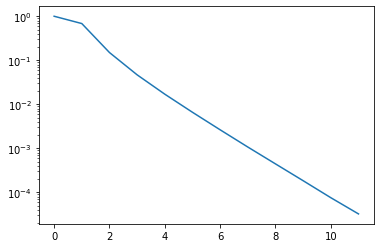

In [6]:
EPS = 5e-5
n_multigrid = 0
u = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
res_arr = [1]
res = 1
model(rhs[1].unsqueeze(0))
err_occured = False
while (abs(res) > EPS):
    u = model.iterate(u, model.f)
    residual = model.f-model.grids[0].Knet(u)
    res_old = res
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_multigrid, res)
    n_multigrid += 1

    if(res == torch.inf or math.isnan(res)):
        err_occured = True
        break

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_multigrid, "multi-grid iterations ")
plt.plot(res_arr)
plt.yscale('log')

In [7]:
model_dir = 'Model/multigrid_rhs_res'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mlist = list(model.parameters())
print('Ratio:', mlist[0][:])
print('Restriction kernel:', mlist[1][0][0])
print('Restriction kernel shape:', mlist[1].shape)
print('Interpolation kernel:', mlist[2][0][0])
print('Interpolation kernel shape:', mlist[2].shape)

Ratio: tensor([4., 1.])
Restriction kernel: tensor([[0.0625, 0.1250, 0.0625],
        [0.1250, 0.2500, 0.1250],
        [0.0625, 0.1250, 0.0625]], grad_fn=<SelectBackward0>)
Restriction kernel shape: torch.Size([1, 16, 3, 3])
Interpolation kernel: tensor([[0.2500, 0.5000, 0.2500],
        [0.5000, 1.0000, 0.5000],
        [0.2500, 0.5000, 0.2500]], grad_fn=<SelectBackward0>)
Interpolation kernel shape: torch.Size([16, 1, 3, 3])


In [8]:
def freeze_kernels(para_list, list):
    '''Freeze the kernels in list, second and third term are R and P'''
    for i in list:
        para_list[1].grad[:,i] = torch.zeros_like(para_list[1].grad[:,i])
        para_list[2].grad[i,:] = torch.zeros_like(para_list[2].grad[i,:])
        

def rewrite_kernels(para_list, list, kernels):
    '''Overwrite the kernels in list to be 'kernels', second and third term are R and P '''
    for i in list:
        para_list[1].grad[:,i] = kernels[0]
        para_list[2].grad[i,:] = kernels[1]

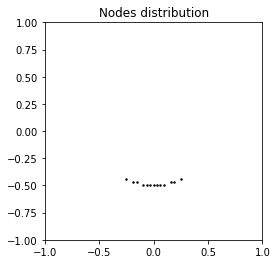

In [9]:
kernel_i = 6
mesh = MeshHandler(outfile="Results/plate_mesh.vtk")
plot.plot_pattern(mesh, key=kernel_i)

In [10]:
freeze_list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15] # freeze a kernel
freeze_list.remove(kernel_i)

def train_one_epoch():
    running_loss = 0.
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad() # zero the gradients for every batch
        u_out = model(data)
        loss_i = model.loss(u_out)
        
        loss_i.backward()
        para_list = list(model.parameters())
        # freeze parts of the grad to be zeros, e.g., param.grad[:,1:] = torch.zeros_like(param.grad[:,1:])
        freeze_kernels(para_list, freeze_list)
        optimizer.step()
        # overwrite the new param to be the original weight
        rewrite_kernels(para_list, freeze_list, [linear_tensor_R, linear_tensor_P])
        running_loss += loss_i.item()
    
    last_loss = running_loss/(i+1)
    return last_loss

In [11]:
num_epoch = 300
best_vloss = 1_000_000.
model_name = 'model_mg_interface_kernel'+str(kernel_i)

loss_train = []
for epoch in range(num_epoch):
    model.train(True)
    avg_loss = train_one_epoch()
    print(epoch, avg_loss)
    
    # Track best performance, and save the model's state
    mpath = os.path.join(model_dir,model_name+'.pth')
    torch.save(model.state_dict(), mpath)
    loss_train.append(avg_loss)

0 17.726118206977844
1 17.361916422843933
2 17.828253388404846
3 17.17346316576004
4 17.34565281867981
5 18.105662524700165
6 17.914560317993164
7 17.306097328662872
8 17.805160760879517
9 17.631295084953308
10 17.059274315834045
11 17.500743329524994
12 17.91236388683319
13 17.709617912769318
14 17.67650979757309
15 17.72671490907669
16 18.018174529075623
17 17.581015288829803
18 17.581379771232605
19 17.49834156036377
20 17.676724910736084
21 17.7671799659729
22 17.1826434135437
23 17.62804251909256
24 17.524925887584686
25 17.700832962989807
26 17.426546812057495
27 17.216128647327423
28 17.533574283123016
29 17.592028439044952
30 17.65677762031555
31 17.466641426086426
32 17.429408013820648
33 17.785216331481934
34 17.617010951042175
35 17.782577395439148
36 17.384921967983246
37 17.726989269256592
38 17.917857229709625
39 17.25427770614624
40 17.615167796611786
41 17.58702003955841
42 18.024431109428406
43 17.430023908615112
44 17.514252185821533
45 18.367780447006226
46 17.379607

Text(0.5, 0, 'epoch')

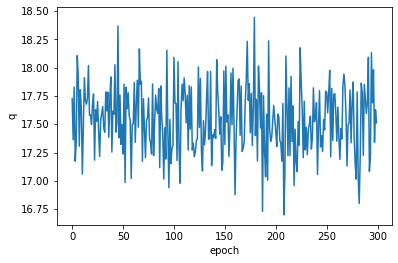

In [12]:
plt.plot(loss_train)
plt.ylabel('q')
plt.xlabel('epoch')

In [13]:
# save the list
np.save(os.path.join(model_dir,model_name+'.npy'),loss_train)

In [14]:
print('Learned parameters:')
print('Ratio:', mlist[0][:])
print('Restriction kernel:', mlist[1][0][kernel_i])
print('Interpolation kernel:', mlist[2][kernel_i][0])

print()

print('Previous parameters:')
print('Ratio:', mlist[0][:])
print('Restriction kernel:', mlist[1][0][kernel_i-1])
print('Interpolation kernel:', mlist[2][kernel_i-1][0])


Learned parameters:
Ratio: tensor([4., 1.])
Restriction kernel: tensor([[ 0.0625, -0.3361,  0.0625],
        [ 0.1307,  0.2602,  0.1340],
        [ 0.0625,  0.1250,  0.0625]], grad_fn=<SelectBackward0>)
Interpolation kernel: tensor([[0.2406, 0.5137, 0.2362],
        [0.5159, 1.0102, 0.5091],
        [0.2547, 0.5012, 0.2552]], grad_fn=<SelectBackward0>)

Previous parameters:
Ratio: tensor([4., 1.])
Restriction kernel: tensor([[0.0625, 0.1250, 0.0625],
        [0.1250, 0.2500, 0.1250],
        [0.0625, 0.1250, 0.0625]], grad_fn=<SelectBackward0>)
Interpolation kernel: tensor([[0.2500, 0.5000, 0.2500],
        [0.5000, 1.0000, 0.5000],
        [0.2500, 0.5000, 0.2500]], grad_fn=<SelectBackward0>)


In [15]:
# import the learned model
model.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))

<All keys matched successfully>

In [16]:
EPS = 5e-5
n_multigrid = 0
n = 2**4
u = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
res_arr = [1]
res = 1
model(rhs[0].unsqueeze(0))
while (abs(res) > EPS):
    u = model.iterate(u, model.f)
    residual = model.f-model.grids[0].Knet(u)
    res_old = res
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_multigrid, res)
    n_multigrid += 1

print("Solution converges after", n_multigrid, "multi-grid iterations ")

0 0.020392386242747307
1 0.00393664138391614
2 0.0009682251838967204
3 0.00027726494590751827
4 8.584704482927918e-05
5 2.7657717510010116e-05
Solution converges after 6 multi-grid iterations 


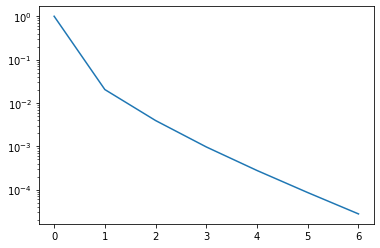

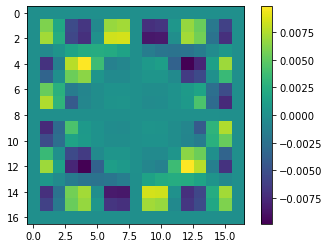

In [17]:
plt.plot(res_arr)
plt.yscale('log')
plot.plot_field(u.detach())

In [18]:
# Test the multigrid iteration
class mgTest(MultiGrid):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, inter_model, n = 64):
        super(mgTest, self).__init__(n, linear_tensor_R, linear_tensor_P, linear_ratio)

        self.size = 2
        self.n = n # total number of grids for finest grid
        self.L = int(np.log2(n)) # number of levels for V-cycle multigrid
        self.x = np.linspace(-1,1,n+1, dtype=np.float32) # grid number is n+1
        self.y = np.linspace(-1,1,n+1, dtype=np.float32)
        self.xx, self.yy = np.meshgrid(self.x, self.y, indexing='xy')
        self.solution = []

        self.w = inter_model.w
        self.conv = inter_model.conv
        self.deconv = inter_model.deconv
        self.conv.requires_grad_(False)
        self.deconv.requires_grad_(False)
        self.w.requires_grad_(False)
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        ff = np.ones_like(self.xx)
        self.grids[0].f = self.grids[0].fnet(torch.from_numpy(ff.reshape(1,1,n+1,n+1))) # assign the finest right hand side with the original rhs
    
    def solve(self):
        '''Return error and residual array'''
        EPS = 5e-5
        n_Vcycle = 0
        self.grids[0].v = torch.zeros((1, 1, self.n+1, self.n+1), requires_grad=False, dtype=torch.float32)
        e_Vcycle, res = 1, 1
        e_arr_Vcycle = [e_Vcycle]
        res_arr_Vcycle = [res]
        err_occured = False
        while (res > EPS):
            u_prev = self.grids[0].v 
            self.grids[0].v = self.iterate(self.grids[0].v,self.grids[0].f)
            e_Vcycle = torch.sqrt(torch.sum((self.grids[0].v - u_prev) ** 2)).item() / torch.sqrt(torch.sum((self.grids[0].v) ** 2)).item()
            e_arr_Vcycle.append(e_Vcycle)
            residual = self.grids[0].f-self.grids[0].Knet(self.grids[0].v)
            res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
            res_arr_Vcycle.append(res)
            print(e_Vcycle, res)
            n_Vcycle += 1
            if(res == torch.inf or math.isnan(res)):
                err_occured = True
                break

        if(err_occured):
            print("The iteration doesn't converge!")
        else:
            print("Solution converges after", n_Vcycle, "V-cycle iterations with relative error of", e_Vcycle)
        return e_arr_Vcycle, res_arr_Vcycle

1.0 0.08181281387805939
0.26272850259453556 0.047538477927446365
0.09104465873135921 0.030080828815698624
0.03705818487343872 0.019312234595417976
0.017780995655296956 0.012318840250372887
0.009823351782767442 0.0078108529560267925
0.005922062127606663 0.004940432962030172
0.003709111919738735 0.0031250251922756433
0.0023590267902511507 0.0019789361394941807
0.0015059681078517587 0.0012544379569590092
0.0009599667994765689 0.0007957518682815135
0.0006135988268229427 0.0005057243397459388
0.0003941372939956756 0.0003218819329049438
0.00024633064107419775 0.00020405740360729396
0.00015676233215167806 0.0001306902413489297
9.753055401247123e-05 8.241531031671911e-05
6.515716063901206e-05 5.349762432160787e-05
3.973952806976783e-05 3.531189213390462e-05
Solution converges after 18 V-cycle iterations with relative error of 3.973952806976783e-05


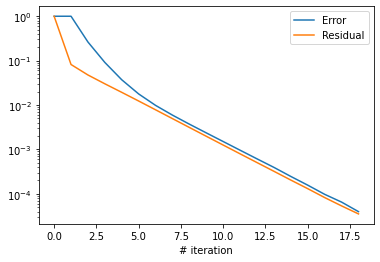

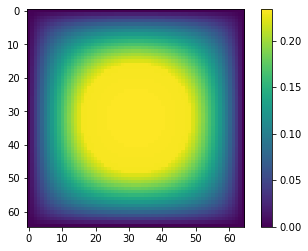

In [19]:
# Multigrid implementation
n = 2**6
prob_mg = mgTest(model, n)

e_arr_Vcycle, res_arr_Vcycle = prob_mg.solve()

plt.plot(e_arr_Vcycle, label='Error')
plt.plot(res_arr_Vcycle, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
#plt.ylabel('Error')
plt.legend()

plot.plot_field(prob_mg.grids[0].v.detach())

In [20]:
def compute_q(res_arr):
    return np.power(res_arr[9]/res_arr[6], 1.0/4)

print("q is: ", compute_q(res_arr_Vcycle))

q is:  0.7094688457127589
